In [27]:
import pandas as pd
import os
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
import seaborn as sns

import matplotlib
font = {'size'   : 22}
matplotlib.rc('font', **font)

# Oefening: Data science bij Disney World
## Overzicht
In deze oefening bekijken we gegevens die wachttijdinformatie bevatten voor alle attracties in Disney World. We valideren eerst de gegeven gegevens en onderzoeken vervolgens een aantal specifieke business questions.


## Deel 1: Het opzetten van je werkruimte
Initialiseer een git-repository op je persoonlijke GitHub-account. Je moet de gegevens niet toevoegen aan deze git-repo (gebruik een .gitignore). Uiteindelijk moet je mij voorzien van een .yml-bestand waarmee ik een virtuele omgeving kan maken waarin ik al je code kan uitvoeren.

**Tip**: Je kan beginnen met werken in een basisomgeving en vervolgens aan het einde van het project een *.yml*-bestand maken. Ook de github pagina kan je op het einde aanmaken waarna je alles toevoegt.

## Deel 2: Inlezen en inspecteren
### Stap 1: De gegevens inlezen en samenvatten
Lees alle wachttijd-csv-bestanden in die zich bevinden in `data/waiting times`. Verzamel ze in één groot dataframe waarin je een extra kolom attractie toevoegt waarin je de naam van de attracties plaatst (die uit de bestandsnaam kunnen worden gehaald).

In [2]:
loc_entities_extra = os.path.join('..', 'data', 'overview data', 'entities_extra.csv')
loc_waiting_times = os.path.join('..', 'data', 'waiting times')
loc_meta = os.path.join('..', 'data', 'overview data', 'metadata.csv')

df_entities_extra = pd.read_csv(loc_entities_extra)
df_meta = pd.read_csv(loc_meta)

In [3]:
dfs = list()
for filename in tqdm(os.listdir(loc_waiting_times)):
    df = pd.read_csv(os.path.join(loc_waiting_times, filename))
    df['attraction'] = filename.replace('.csv', '')
    dfs.append(df)
    
df_waiting_raw = pd.concat(dfs, ignore_index = True)
df_waiting = df_waiting_raw.copy()

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:07<00:00,  7.17it/s]


### Stap 2: Valideer de gegevens met behulp van enkele visuele voorstellingen
Maak een functie die het dataframe dat je zojuist hebt gemaakt, een datum en een lijst met attracties als invoer neemt. De functie moet vervolgens een plot maken waarin je de wachttijd over de gegeven datum hebt voor alle geselecteerde attracties. Je kunt deze functie gebruiken om een gevoel te krijgen voor hoe goed de werkelijke en geposte wachttijden zijn gevuld.

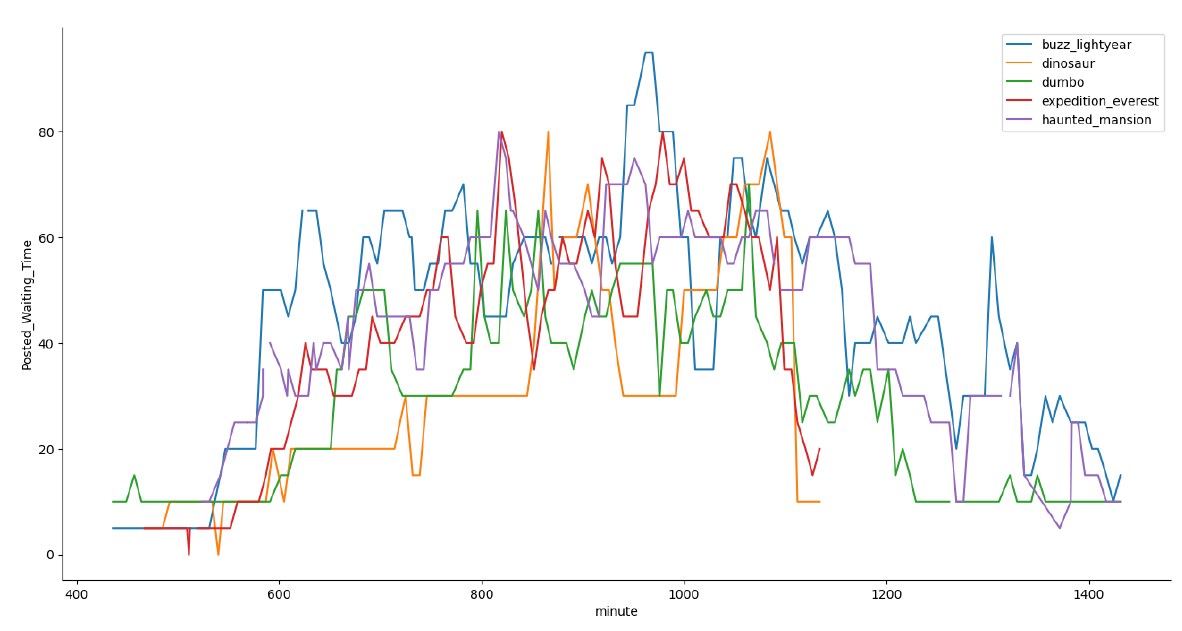

### Preprocessing step

 - Add minute of day.
 - Split dataframe into actual and posted waiting time.
 - Remove all -999 as these are waiting times at times that the attraction is closed.

In [4]:
## Add minutes
df_waiting['datetime'] = pd.to_datetime(df_waiting['datetime'])
# We subtract 3 hours from the day and add them as 180 minutes to account for hours past midnight
df_waiting['minute'] = ((df_waiting['datetime'] - datetime.timedelta(hours = 3)).dt.hour * 60
                            + 180
                            + df_waiting['datetime'].dt.minute)

## Split actual and posted
df_waiting_act = (df_waiting.loc[~df_waiting.SACTMIN.isnull()]
                            .reset_index(drop = True)
                            .drop(['SPOSTMIN'], axis = 1)
                            .rename({'SACTMIN' : 'waiting_time'}, axis = 1))

df_waiting_post = (df_waiting.loc[~df_waiting.SPOSTMIN.isnull()]
                            .reset_index(drop = True)
                            .drop(['SACTMIN'], axis = 1)
                            .rename({'SPOSTMIN' : 'waiting_time'}, axis = 1))

## Restrict to non -999 waiting times
df_waiting_act = df_waiting_act.loc[df_waiting_act.waiting_time > -998]
df_waiting_post = df_waiting_post.loc[df_waiting_post.waiting_time > -998]

In [5]:
def visualize_waiting(df, attractions, date):
    fig, ax = plt.subplots(figsize = (12, 4))
    for attraction in attractions:
        (df.query("date == @date and attraction == @attraction")
                        .plot(x = 'minute',
                                 y = 'waiting_time',
                                 label = attraction,
                                 ax = ax,
                                 marker = 'o'))

    ax.set_ylim(bottom = 0)
    ax.spines[['top', 'right']].set_visible(False)
    return fig, ax

(<Figure size 1200x400 with 1 Axes>, <Axes: xlabel='minute'>)

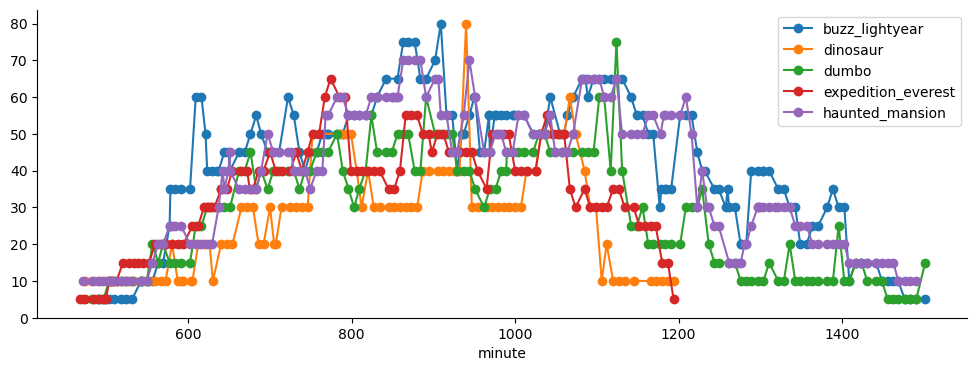

In [6]:
date = '01/02/2015'
attractions = ['buzz_lightyear', 'dinosaur', 'dumbo', 'expedition_everest', 'haunted_mansion']

visualize_waiting(df_waiting_post, attractions, date)

### Stap 3: Onderzoek voor welke attracties we voldoende informatie hebben over de geposte wachttijd.
Kijk naar hoeveel gegevenspunten van geposte wachttijd je per dag hebt voor elke attractie. Op deze manier kun je attracties uitsluiten met te weinig gegevenspunten gemiddeld.

<Axes: ylabel='attraction'>

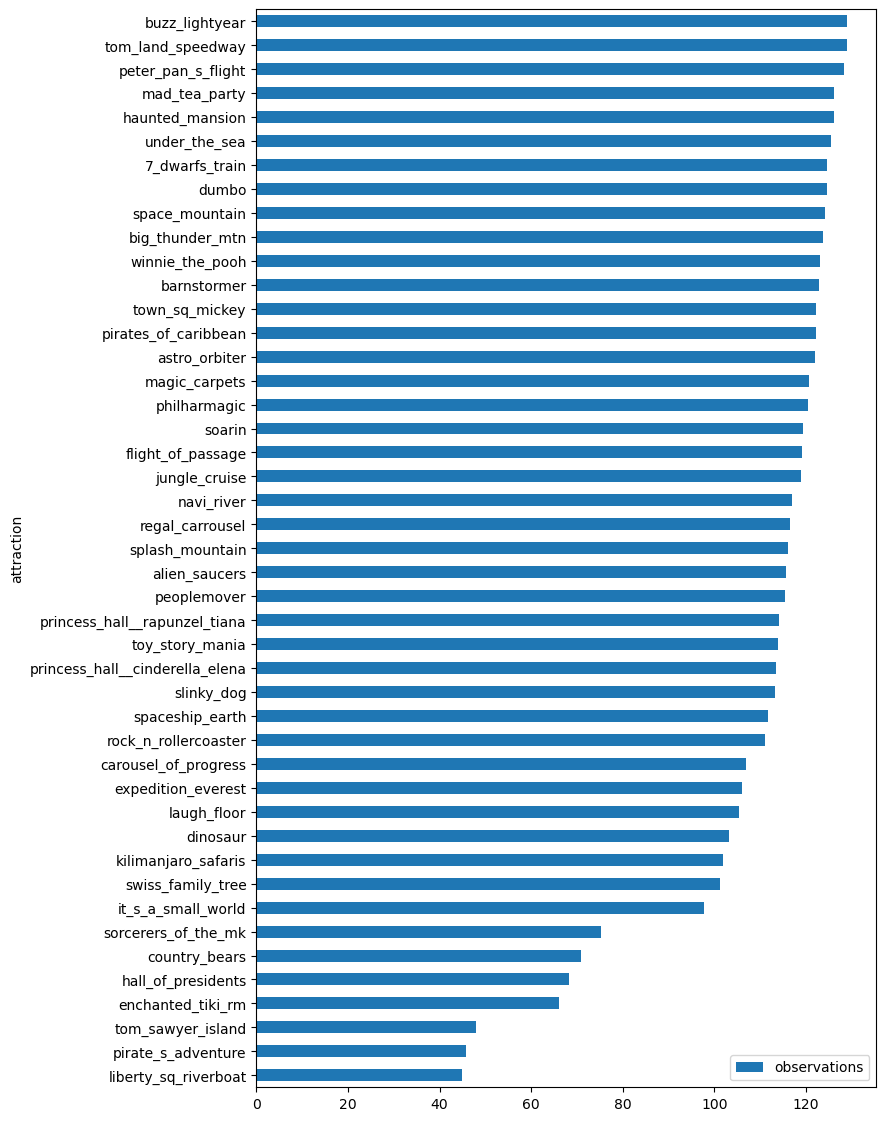

In [7]:
fig, ax = plt.subplots(figsize = (8, 14))

(df_waiting_post.groupby(['date', 'attraction'])
                 .size()
                 .reset_index()
                 .rename({0 : 'observations'}, axis = 1)
                 .groupby('attraction')[['observations']]
                 .mean()
                 .sort_values(by = 'observations')
                 .plot
                 .barh(ax = ax))

### Stap 4: Bestudeer de spreiding van de beschikbaarheid van gegevens voor actuele wachttijdinformatie.

Er lijkt niet zo veel informatie beschikbaar te zijn over de werkelijke wachttijden bij attracties. Is dit omdat we elke dag gewoon beperkte gegevens hebben, of zijn er enkele dagen met veel informatie? Maak een aantal
visualisaties maken om dit te onderzoeken?

<Axes: ylabel='Frequency'>

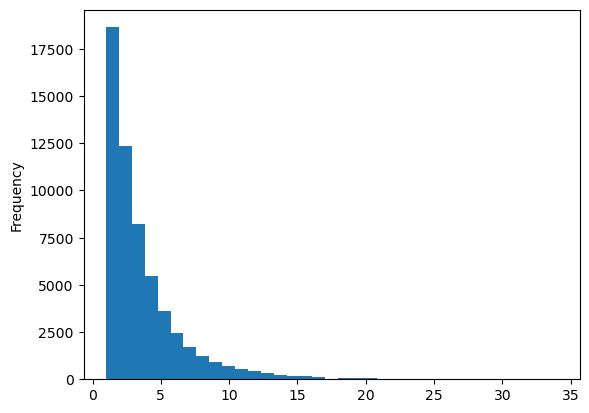

In [8]:
df_observations = (df_waiting_act.groupby(['date', 'attraction'])
                                 .size()
                                 .reset_index()
                                 .rename({0 : 'observations'}, axis = 1)
                                 [['observations', 'attraction', 'date']])

(df_observations['observations'].plot
                                .hist(bins = 35))

## Onderzoeksvraag 1: Vergelijk voorspelde en werkelijke wachttijd
Maak een visualisatie die laat zien hoe de voorspelde en werkelijke wachttijden zich tot elkaar verhouden.

Hiervoor kan je volgende stappen uitvoeren:
 - Zoek voor elke werkelijke wachttijd de vorige en volgende voorspelde wachttijd.
 - Gebruik lineaire interpolatie om de beste schatting van de gepubliceerde wachttijd te vinden voor de werkelijke wachttijd die we onderzoeken.
 - Bereken het verschil tussen de werkelijke en de geposte wachttijd.
 - Maak een histogram van al deze verschillen, een scatterplot is hier ook een geschikte visualizatie.

Je kan ook eens kijken naar enkele specifieke datum & attractie combinaties waarvoor je veel werkelijke wachttijdinformatie hebt en dan de werkelijke en geposte wachttijd uittekenen en vergelijken.

### Compute posted waiting times for all actual times using `interp1d`

In [9]:
dict_act = dict()
for (date, attraction), df_act in df_waiting_act.groupby(['date', 'attraction']):
    dict_act[date, attraction] = df_act

dfs_act = list()
for (date, attraction), df_post in tqdm(list(df_waiting_post.groupby(['date', 'attraction']))):
    if (date, attraction) not in dict_act:
        continue
    df_act = dict_act[date, attraction]
    # We only keep indexes for which actual waiting times lie in the range covered by posted ones.
    idxs_keep = (~((df_act['minute'] <= df_post['minute'].min()) 
                       | (df_act['minute'] >= df_post['minute'].max())))
    df_act = df_act.loc[idxs_keep].copy()
    
    interp_post_waiting = interp1d(df_post['minute'], df_post['waiting_time'])
    df_act['posted'] = interp_post_waiting(df_act['minute'])
    dfs_act.append(df_act)

df_act_validation = pd.concat(dfs_act)

100%|██████████████████████████████████████████████████████████████████████████| 74858/74858 [00:53<00:00, 1397.41it/s]


### Create visualization showing forecast accuracy

In [10]:
df_act_validation['fcst_accuracy'] = df_act_validation['posted'] - df_act_validation['waiting_time']
# TODO: Look into extreme errors in forecast, for now we just filter them out.
idxs_non_extreme = ((df_act_validation['fcst_accuracy'] <= 120) 
                        & (df_act_validation['fcst_accuracy'] >= -120))
df_act_validation = df_act_validation.loc[idxs_non_extreme]

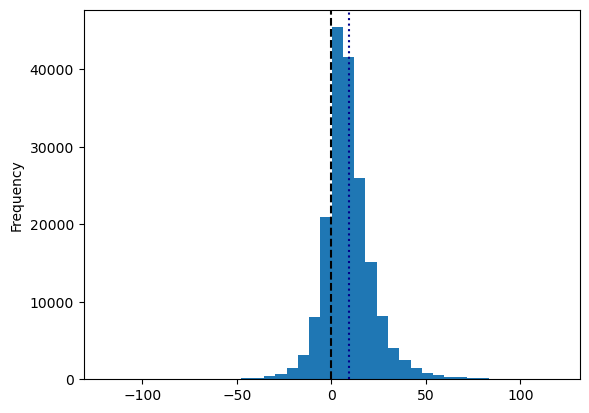

In [11]:
fig, ax = plt.subplots()
df_act_validation['fcst_accuracy'].plot.hist(bins = 40, ax = ax)
ax.axvline(0, color = 'k', ls = '--')
ax.axvline(df_act_validation['fcst_accuracy'].mean(), color = 'darkblue', ls = ':')

In [12]:
# Show the lines (date + attraction) with many actual waiting time observation
df_observations.sort_values(by = 'observations').tail(10)

,observations,attraction,date
41246,27,big_thunder_mtn,09/25/2021
43518,28,pirates_of_caribbean,10/10/2021
43505,28,expedition_everest,10/10/2021
25313,28,expedition_everest,06/09/2021
11864,29,big_thunder_mtn,03/13/2021
42149,30,big_thunder_mtn,10/01/2021
21259,30,toy_story_mania,05/14/2021
33070,33,pirates_of_caribbean,08/01/2021
12787,34,big_thunder_mtn,03/19/2021
15224,34,big_thunder_mtn,04/04/2021


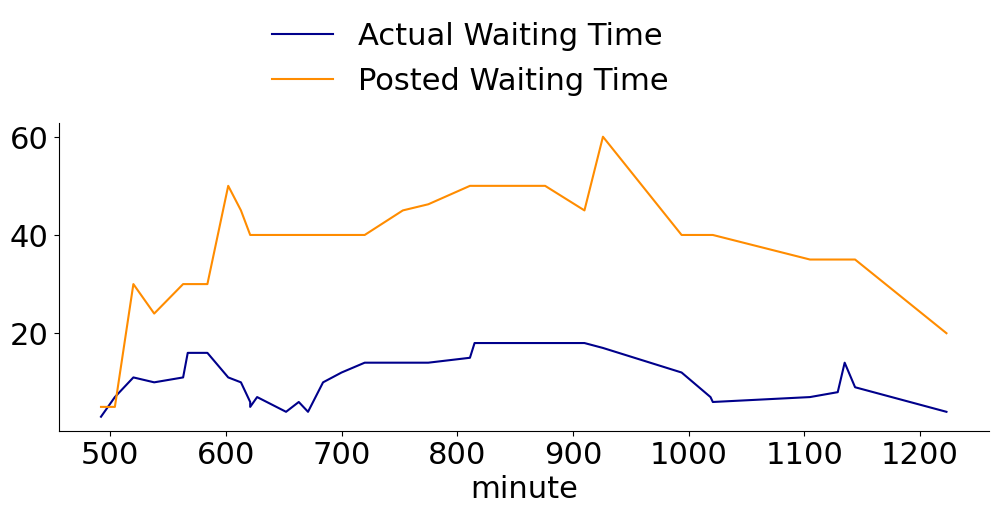

In [35]:


# TODO: Dit kunnen we nog op een veel meer gestroomlijnde manier doen.
attraction = 'big_thunder_mtn'
date = '03/19/2021'


fig, ax = plt.subplots(figsize = (12, 4))

(df_act_validation.query("attraction == @attraction and date == @date")
                  .plot(x = 'minute',
                           y = ['waiting_time', 'posted'],
                           ax = ax,
                           color = ['darkblue',
                                        'darkorange']))

ax.legend(["Actual Waiting Time",
              "Posted Waiting Time"],
              frameon = False,
              bbox_to_anchor = (.2,1))

ax.spines[['top', 'right']].set_visible(False)

## Onderzoeksvraag 2: beste dag voor attracties
Filter de attracties met `category_code == ride` uit en zoek uit welke dag van de week
(maandag/dinsdag/...) deze attracties gemiddeld de kortste wachttijden hebben. 

Probeer in een tweede stap verder specifiek te kijken naar de combinatie van dag van de week en `HOLIDAYM`-waarde. Idealiter zou je ook uitleggen wat dit betekent.

We use posted waiting times as we have much more data for these. However, if the stakeholder is actually interested in actual waiting times, we should adjust the analysis.

#### Investigate the waiting times per day of week for rides.

In [14]:
rides = list(df_entities_extra[['short_name', 'category_code']]
                         .query("category_code == 'ride'")
                         .short_name)

rides = [ride.replace(' ', '_').replace("'", '_').lower() for ride in rides]

In [15]:
# TODO: We are missing 3 rides we only have 21 out of 24 available
# To check if they are in waiting times and matched poorly or not in waiting time data.

df_waiting_post_rides = df_waiting_post.query('attraction in @rides').copy()
df_waiting_post_rides['Day of week'] = df_waiting_post_rides.datetime.dt.strftime('%A')

<Axes: xlabel='Day of week'>

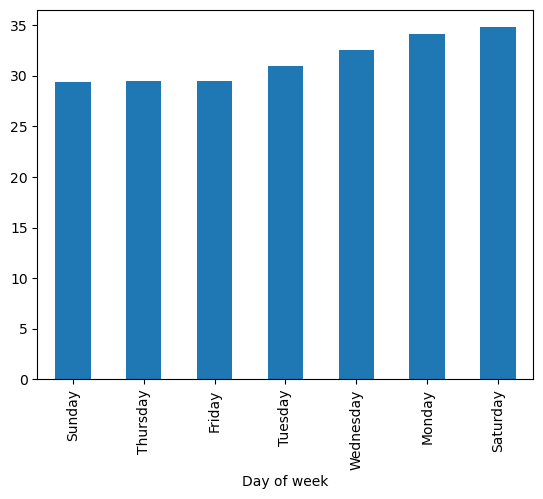

In [16]:
(df_waiting_post_rides.groupby(['Day of week'])['waiting_time']
                         .mean()
                         .sort_values()
                         .plot
                         .bar())

#### Investigate impact of day of week & HOLIDAYM on waiting times for rides in Disney World

In [17]:
df_waiting_post_rides_hol = pd.merge(left = df_waiting_post_rides,
                                        right = df_meta[['DATE', 'HOLIDAYM']],
                                        left_on = 'date',
                                        right_on = 'DATE')

In [18]:
df_plot = (df_waiting_post_rides_hol.groupby(['Day of week', 'HOLIDAYM'])
                                       ['waiting_time']
                                       .mean()
                                       .reset_index())

<Axes: xlabel='Day of week', ylabel='waiting_time'>

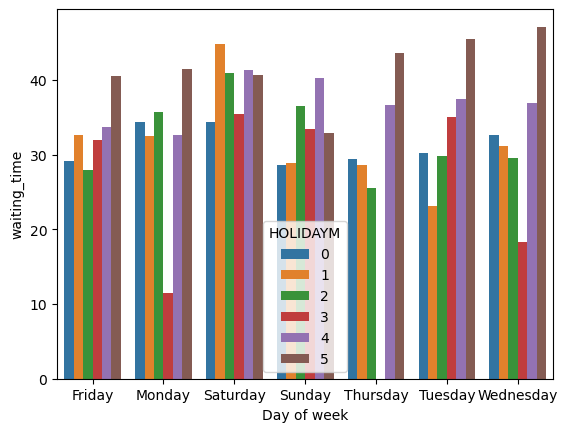

In [19]:
sns.barplot(data = df_plot,
               x = 'Day of week',
               y = 'waiting_time',
               hue = 'HOLIDAYM')